In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# make emission matrix
def make_emission(host, guest):
    emission = np.zeros((len(host), len(host), 2))
    emission[:,:,0] = host
    emission[:,:,1] = guest

    # reorder the axis
    return np.swapaxes(emission, 0, 1)

In [3]:
# load in the data
transition = np.load('vector-data/tensor.npy')
host = np.load('vector-data/transition_matrix_host.npy')
guest = np.load('vector-data/transition_matrix_guest.npy')
obs = np.load('vector-data/observations.npy')
initial = np.array([0.9, 0.1])

In [4]:
emission = make_emission(host, guest)

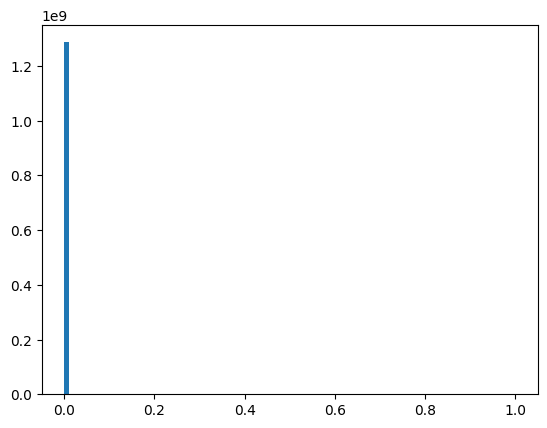

In [5]:
values = emission.flatten()
# values1 = values / np.sum(values)
# cumulative = np.cumsum(values1)
# plt.plot(cumulative)
# plt.show()
plt.hist(values, bins=100)
plt.show()



In [11]:
print(np.sum(values == 0))
len(values)

1250300882


1287375282

In [6]:
# Adjust transition matrix to add epsilon values to avoid zero probabilitiese
eps = .001

In [7]:
def tensor_viterbi(obs, transition, emission, initial, structured = None):
    """Run the Viterbi algorithm with a conditioned tensor for the emission probabilities.
    Inputs:
        obs - ndarray (n,): observation sequence of indexes (includes a unique start token)
        transition - ndarray (d,2,2): transition tensor of probabilities (index, row, col)
        emission - ndarray (d,d,2): emission tensor of probabilities (index, row, col)
        initial - ndarray (2,): initial state probabilities
        structured - (optional) ndarray (n,): structured sequence of indexes

    Outputs:
        state_sequence - ndarray (n,): most likely state sequence of indexes
    """
    # Matt Ignore structured variable


    # Get the lengths and correct indices
    start_index = obs[0]
    obs = obs[1:]
    n = len(obs)
    d = transition.shape[0]
    
    # Initialize the viterbi matrix and the backpointers
    eta = np.zeros((n,2))
    backpointers = np.zeros((n,2), dtype=int)

    # Initialize the first row
    eta[0] = np.log(initial) + np.log(emission[start_index,obs[1],:])
    obs = obs[1:]

    # Loop through the rest of the rows
    for i in range(1,n-1):
        b = emission[obs[i-1],obs[i],:]
        # check if any of the emission probabilities are zero
        if np.any(b == 0):
            # find the index of the zero probability
            zero_index = np.where(b == 0)
            # replace the zero probability with a small epsilon value
            b[zero_index] = eps
            # normalize the emission probabilities
            b = b / np.sum(b)
        eta_candidate = np.log(transition[obs[i-1],:,:]) + np.log(b) + eta[i-1][np.newaxis, :]
        # eta_candidate = np.log(transition[obs[i-1],:,:]) * eta[i-1][np.newaxis, :] + np.log(emission[obs[i-1],obs[i],:])[:,np.newaxis] #### if statement goes here to replace 0 in the emission tensor
        eta[i] = np.max(eta_candidate, axis=1)
        backpointers[i] = np.argmax(eta_candidate, axis=1)

    # Backtrack
    state_sequence = np.zeros(n, dtype=int)
    state_sequence[-1] = np.argmax(eta[-1])
    for i in range(n-2,-1,-1):
        state_sequence[i] = backpointers[i+1,state_sequence[i+1]]

    # Return the state sequence
    return state_sequence


In [8]:


# Run the viterbi algorithm
state_sequence = tensor_viterbi(obs, transition, emission, initial)



[[1. 0.]
 [0. 1.]]
[[-5.70378247         inf]
 [        nan        -inf]]


/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_53716/4275070506.py:34: RuntimeWarning: divide by zero encountered in log
  eta_candidate = np.log(transition[obs[i-1],:,:]) * eta[i-1][np.newaxis, :] + np.log(emission[obs[i-1],obs[i],:])[:,np.newaxis]
/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_53716/4275070506.py:34: RuntimeWarning: invalid value encountered in add
  eta_candidate = np.log(transition[obs[i-1],:,:]) * eta[i-1][np.newaxis, :] + np.log(emission[obs[i-1],obs[i],:])[:,np.newaxis]


In [9]:
print(state_sequence)

0


In [10]:
transition[0]

array([[0.99842366, 0.04561404],
       [0.00157634, 0.95438596]])